In [2]:
import numpy as np

from matplotlib import pyplot as plt

from copy import deepcopy

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.optim import Adam

# ours
from approach.lstm_forecast import ShallowForecastLSTM
from util.utils import train_one_step, test_model, predict, SequenceDataset
from util.fed_utils import FedAvg_loop


### Introduction

- Contexte: données de séries temporelles, décentralisées sur des "noeuds".
- Contraintes: les noeuds ne peuvent pas échanger leurs données.
- But: entraîner un modèle prédictif (ici forecasting) sur chaque noeud.

Federated learning: tirer parti des paramètres des modèles des autres noeuds pour améliorer les capacités prédictives de chaque modèle (locale). # référence FedAvg + descriptif deux phrases

### Schéma
<font color="orange">Noeuds</font> - <font color="grey">Générateur données</font> - <font color="purple">Fédérateur (ou serveur central)</font>

![image](scheme_fl.PNG)

In [ ]:
# boxplots des perf

#### 0. Les données: séries temporelles (une par noeud)

Une série temporelle constitue une séquence de mesures indexées par le temps. Lorsqu'à chacun de ces instants de temps, une seule variable d'état est mesurée (e.g. température, fréquentation d'une station de bus, etc), la série temporelle est dite univariée. A fortiori, lorsque $\it{plusieurs}$ variables sont mesurées à un instant donné, on dit que la série temporelle est $\it{multivariée}$ (ou multivaluée).

On note $x_k(t)$ l'échantillon mesuré sur la variable $k$ à l'instant $t$ pour $k = 1 \dots K$ et $t = 0, \dots T$.

 Souvent, quand on étudie une série temporelle multivariée, on conjecture que les $K$ variables (ou un sous-ensemble) sont corrélées entre elles au cours du temps, c'est-à-dire que les variables $x_{k_1}$ et $x_{k_2}$ évoluent conjointement. Dans ce cas, cela suppose que pour prédire la valeur future $x_{k_1}(T+1)$ (non mesurée) à partir de ses valeurs passées $x_{k_1}(t=0) \dots x_{k_1}(t=T)$, il faut aussi considérer les valeurs passées $x_{k_2}(t=0) \dots x_{k_2}(t=T)$.

#### 1. Le modèle de prediction (forecasting)

Ici, on souhaite entraîner un modèle pour prédire les valeurs futures de chacune des variables (forecasting), c'est-à-dire donner une estimation de $x_{1}(T+1), \dots x_{k}(T+1) \dots x_{K}(T+1)$. Chaque modèle $k$ (un réseau de neurones type Long Short Term Memory) va alors tenter d'approximer une fonction $f_k$ telle que $x_{t+1} = f_k (x_t, \dots x_{t-1} \dots )$. La fonction de prédiction $f_k$ représente le modèle $k$ et comporte, disons $p$ paramètres $w_{1,k}, \dots w_{1,p}$.

#### 2. Contexte federated learning

Dans notre contexte, on suppose que les données d'une variable $k$ sont mesurées sur un noeud $k$. Ces données ne peuvent être communiquées et partagées à d'autres noeuds. Il est donc impossible de construire un modèle globale à partir des données de toutes les variables. On va donc entraîner un modèle par noeud. Afin de prendre en considération ces éventuelles corrélations, on peut entraîner chaque modèle en partageant non pas les données mais les paramètres de chaque modèle à un serveur centrale. Une stratégie simple, appelée Federated Averaging, consiste à moyenner les paramètres de chacun des modèles, plus concrètement:
- (1.) le modèle local $k$ apprend sur ses données $x_{k}(t=0) \dots x_{k}(t=T)$,
- (2.) le modèle $k$ envoie ses paramètres, disons $w_{1,k}, \dots w_{p,k}$ au serveur central,
- (3.) le serveur central calcule la moyenne $w_{1}^c, \dots w_{p}^c$ des $p$ paramètres des $K$ modèles: e.g. pour un paramètre $w_{p}^c = \frac{1}{K} \sum_{i=1}^{K} w_{p,i}$,
- (4.) le serveur central renvoie les paramètres moyennés au noeud $k$,
- (5.) le modèle local $k$ reçoit les paramètres  $w_{1}^c, \dots w_{p}^c$, et recommence à l'étape (1.).

Référence bibliographique de l'algorithme Federated Averaging: H. B. McMahan, E. Moore, D. Ramage, S. Hampson, and B. Agüera y Arcas, “Communication-Efﬁcient Learning of Deep Networks from Decentralized Data,” in AISTATS, 2017, vol. 54.

### Objectif du notebook:
- appliquer Federated Averaging pour prédire dans le temps (forecaster) sur chaque noeud,
- comparer à l'apprentissage non-fédéré (les noeuds ne communiquent pas entre eux),
- comparer à l'apprentissage centralisé "classique", où les données de chacune des variables ne sont pas distribuées et sont utilisées pour entraîner un seul modèle sur une "grosse" série temporelle multivariée.

### Application et comparaison

Ici on suppose que chaque noeud contient les données d'une seule série temporelle.

In [5]:
## reference dataset: https://github.com/rofuyu/exp-trmf-nips16/
x_data = np.load("./datasets/traffic.npy")
T_size, p = x_data.shape
n_clients = 50 # reduced number for the example
t_grid = np.arange(0, T_size)

# common to all experiments
T_train = int(0.70 * T_size)
lag = 40 # number of time-consecutive samples within a mini batch

In [3]:
n_epoch = 100
batch_size = 2**3

Graphes des données de quelques noeuds $x_0 \dots x_{15}$ en fonction du temps.

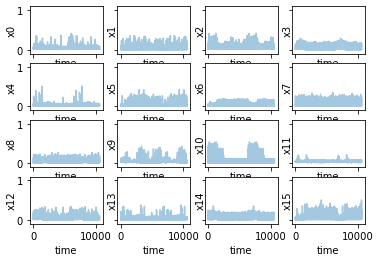

In [4]:
fig, axs = plt.subplots(4, 4, sharex=True, sharey=True)
axs = axs.ravel()

axs[0].set_ylim((-0.1, 1.1))
for k in range(16): # 16 clients
    axs[k].plot(
        t_grid, x_data[:, k],
        alpha=0.4
        )
    axs[k].set_ylabel(f'x{k}', labelpad=-0.5)
    axs[k].set_xlabel('time')

In [5]:
# table des matières

#### I. Entraînements NON-fédérés

Objectif: pour chaque variable indexées $k$, $x_1 \dots x_{K}$, on veut entraîner un modèle qui prédise $x_k(t+1)$ selon ses valeurs passées $x_k(t), x_k(t-1), \dots$

Ici nous entraînons un modèle par noeud, indépendamment des (données et modèles) des autres noeuds.

On commence par créer un dataset par variable (ce qui est naturellement le cas dans un contexte fédéré). Chaque dataset est ensuite divisé en deux ensembles training/testing puis centré-reduit.

In [6]:
train_loaders, test_loaders = [], []

# one scaler for each node
scalers =  [StandardScaler(with_mean=True, with_std=True) for k in range(n_clients)]

for k in range(n_clients):
    
    train_loaders.append(
        DataLoader(
            SequenceDataset(
                scalers[k].fit_transform(x_data[:T_train, k][:, np.newaxis]), # centrer-réduire les données train du client k
                lag=lag
            ),
            batch_size=batch_size, shuffle=True
        )
    )

    test_loaders.append(
        DataLoader(
            SequenceDataset(
                scalers[k].transform(x_data[T_train:, k][:, np.newaxis]),
                lag=lag
            ),
            batch_size=batch_size, shuffle=False # makes the data same when batches are requested at different times
        )
    )

Nous choisissons un modèle de réseaux de neurones récurrents LSTM (Long Short Time Memory) à une couche avec un petit nombre de neurones (pour l'exemple). Chaque noeud aura la même architecture de modèle mais sera entraîné sur ses propres données uniquement.

In [7]:
# desgin the model
num_hidden_units = 50
models_nofed = [ShallowForecastLSTM(num_var=1, hidden_units=num_hidden_units) for k in range(n_clients)]

Enfin, nous fixons la procédure d'entraînement qui implique elle-même le choix d'une fonction d'erreur à minimiser, un minimiseur, un pas d'apprentissage, etc.

In [8]:
# train the models
loss_function = nn.MSELoss()
learning_rate = 1e-2

optimizers = [Adam(
    models_nofed[k].parameters(),
    lr=learning_rate,
    betas=(0.60, 0.75),
    weight_decay=1e-2
) for k in range(n_clients)]

# auto-réglage du pas d'apprentissage à chaque itération sur chaque client
schedulers = [ReduceLROnPlateau(optimizers[k], 'min', patience = 7) for k in range(n_clients)]

# 
train_loss_epoch = np.empty((n_epoch, n_clients))
test_loss_epoch = np.empty_like(train_loss_epoch)

# for each client
for k in range(n_clients):
    print(f'==Learning model of node#{k}==')

    # for each learning step
    for i_epoch in range(n_epoch):
        print(f'------\n Epoch {i_epoch}')

        # train
        train_loss_epoch[i_epoch, k], model_k = train_one_step(
            train_loaders[k], models_nofed[k], loss_function, optimizer=optimizers[k]
            )

        # test
        test_loss_epoch[i_epoch, k] = test_model(
            test_loaders[k], models_nofed[k], loss_function, verbose=True)

        # learning rate decay
        schedulers[k].step(test_loss_epoch[i_epoch, k])
        
        if i_epoch == n_epoch - 1:
            models_nofed[k] = deepcopy(models_nofed[k])


==Learning model of node#0==
------
 Epoch 0
Train loss: 0.421621166014675
Test loss: 0.28476582777016957
------
 Epoch 1
Train loss: 0.415272119354751
Test loss: 0.17295913762246992
------
 Epoch 2
Train loss: 0.3976716299504001
Test loss: 0.16631741965276375
------
 Epoch 3
Train loss: 0.3818273565969309
Test loss: 0.17358483630877636
------
 Epoch 4
Train loss: 0.40731670546208837
Test loss: 0.1758179753087461
------
 Epoch 5
Train loss: 0.3950205595626645
Test loss: 0.17209748174380557
------
 Epoch 6
Train loss: 0.404951928939632
Test loss: 0.1569939172739909
------
 Epoch 7
Train loss: 0.40869313659102585
Test loss: 0.1604176927739121
------
 Epoch 8
Train loss: 0.3935846272549588
Test loss: 0.18109464113394114
------
 Epoch 9
Train loss: 0.40093624352092466
Test loss: 0.15608150579131463
------
 Epoch 10
Train loss: 0.39183594741015915
Test loss: 0.1795854985157577
------
 Epoch 11
Train loss: 0.3973450648812053
Test loss: 0.16518167957313998
------
 Epoch 12
Train loss: 0.39040

In [9]:
# average testing loss (across clients) along the iterations
print('Global testing loss')
np.average(test_loss_epoch, axis=1, weights=np.ones(n_clients))

Global testing loss


array([0.22457359, 0.21060187, 0.20737265, 0.20581967, 0.20426018,
       0.20624885, 0.20160615, 0.20423488, 0.20448044, 0.2014617 ,
       0.21065651, 0.20467555, 0.20101749, 0.20010225, 0.20018419,
       0.19787372, 0.1987576 , 0.19732356, 0.19585934, 0.19374323,
       0.19357188, 0.19181742, 0.19257564, 0.19126294, 0.19067758,
       0.19180054, 0.18993408, 0.18988325, 0.18925767, 0.19016961,
       0.1892107 , 0.18896299, 0.1894838 , 0.18936363, 0.1891324 ,
       0.18907604, 0.18825829, 0.1885392 , 0.18818518, 0.1885284 ,
       0.18824281, 0.18839435, 0.18787254, 0.18839181, 0.18810859,
       0.18832194, 0.1880539 , 0.18789928, 0.18799999, 0.18772348,
       0.18782702, 0.18774981, 0.18775258, 0.18769343, 0.18768459,
       0.18769283, 0.18765834, 0.18763967, 0.18764461, 0.1876495 ,
       0.18763203, 0.18762134, 0.18761762, 0.18760803, 0.18762705,
       0.18761821, 0.1875939 , 0.18760013, 0.18761943, 0.18761025,
       0.18758903, 0.18761781, 0.18761393, 0.18759365, 0.18759

Visualisation des erreurs d'entraînement/test par noeud.

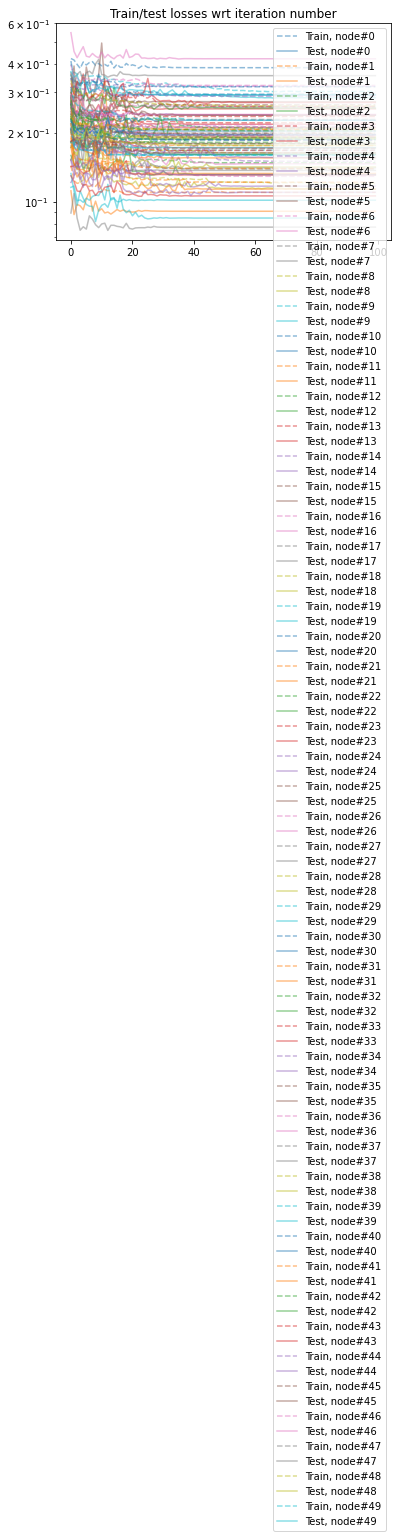

In [10]:
for k in range(n_clients):
    # make a function
    plt.plot(train_loss_epoch[:, k], label=f'Train, node#{k}', color=f'C{k}', alpha=0.5, linestyle='dashed')
    plt.plot(test_loss_epoch[:, k], label=f'Test, node#{k}', color=f'C{k}', alpha=0.5, linestyle='solid')

plt.title('Train/test losses wrt iteration number')
plt.yscale('log')
plt.legend()
plt.show()

Visualisation des prédictions/vraies valeurs sur les ensembles d'entraînement/test.

In [11]:
t_train, t_test = np.arange(0, T_train), np.arange(T_train, T_size)

In [12]:
def plot_client_pred_truth(idx_client, models, train_samples=True, timesteps=t_train):
    """plot samples vs predictions"""

    # compute prediction
    if train_samples:
        x_pred = scalers[k].inverse_transform(predict(train_loaders[k], models[k]).numpy())
    else:
        x_pred = scalers[k].inverse_transform(predict(test_loaders[k], models[k]).numpy())

    # plot the time series
    if train_samples:
        plt.plot(timesteps, x_data[:T_train, idx_client], marker='o', label='Truth', color='C0', alpha=0.25)
    else:
        plt.plot(timesteps, x_data[T_train:, idx_client], label='Truth',  marker='o', color='C0', alpha=0.25)

    plt.plot(timesteps, x_pred, label='Prediction', color='red', alpha=0.25)
    plt.legend(); plt.show()

Graphe de la série temporelle (données de test) du client $k$ et les prédictions associées du modèle $k$.

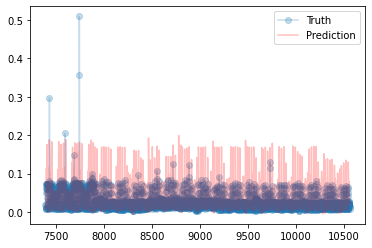

In [19]:
plot_client_pred_truth(
    idx_client=4,
    models=models_nofed,
    train_samples=False,
    timesteps=t_test
    )

### II. Entrainements fédérés

Objectif: pour chaque variable indexées $k$, $x_1 \dots x_{K}$, on veut entraîner un modèle qui prédise $x_k(t+1)$ selon ses valeurs passées $x_k(t), x_k(t-1), \dots$ dans le contexte fédéré. Les modèles locaux (noeuds) sont d'abord entraînés indépendemment les uns des autres (comme en I.), puis ils partagent leur modèle (poids du LSTM) au serveur central (fédérateur) qui lui-même aggrège les modèles (poids $\textit des$ LSTM). Ce modèle aggrégé est renvoyé à chaque client qui réitère un entraînement localement.

Ce processus itérafif, appelé ''communication round'', entre les noeuds locaux et le serveur central, peut être répété plusieurs fois (n_cr fois).
n_cr: number of communication rounds.

In [14]:
models_fed, local_losses_bfr_fedavg, local_losses_aft_fedavg, global_loss  = FedAvg_loop(
    call_basemodel=ShallowForecastLSTM,
    archi_basemodel={'n_inputs': 1, 'n_hidden': 10},
    train_sets=train_loaders,
    test_sets=test_loaders,
    n_cr=5, n_local_epochs=n_epoch,
    lr= 10**-2
)

Communication round 0
-------------------
**Learning client#0
--------------
Train loss: 0.6727781475610322
Train loss: 0.4192871586898406
Train loss: 0.3410632583912154
Train loss: 0.31356988683543513
Train loss: 0.2950590097890195
Train loss: 0.2821415586174552
Train loss: 0.271294579244757
Train loss: 0.2614537378210167
Train loss: 0.25851896411469166
Train loss: 0.25139340914627617
Train loss: 0.2544107589043185
Train loss: 0.24343890050016403
Train loss: 0.24317135973528603
Train loss: 0.23944045976497277
Train loss: 0.23347850664149872
Train loss: 0.2371678104386282
Train loss: 0.23625749564660084
Train loss: 0.23089827400734508
Train loss: 0.2357338360650994
Train loss: 0.2295063505904473
Train loss: 0.2325175581058967
Train loss: 0.23258813072194534
Train loss: 0.23218376356735423
Train loss: 0.22795901428604473
Train loss: 0.21988255784630642
Train loss: 0.2229936871813959
Train loss: 0.21429893481862647
Train loss: 0.21970598563326127
Train loss: 0.21667626791583774
Train los

KeyboardInterrupt: 

In [ ]:
plot_client_pred_truth(
    idx_client=1,
    models=models_fed,
    train_samples=False,
    timesteps=t_test
    )

### III. Entraînement centralisé

Ici, on sort du contexte décentralisé, où on entraîne un modèle par noeud. Cette fois-ci, on est dans le cas classique: les données forment un dataset complet centralisé. Un modèle est entraîné à partir de ce dataset complet (toutes les données). 

Dans ce contexte, les corrélations entre variables $k=1 \dots K$ influencent le modèle appris. Il est important de comprendre que dans les étapes I. et II. ces corrélations sont ingorées par construction (par conséquent les modèles des étapes I. et II. ne reposent que sur les valeurs observée de chacune des variables).

In [ ]:
# scale the data
## one scaler for the whole dataset as we only have a centralized one
scaler =  StandardScaler(with_mean=True, with_std=True)

train_dataset = SequenceDataset(
    scaler.fit_transform(x_data[:T_train, :n_clients]), lag=lag
    )
test_dataset = SequenceDataset(
    scaler.transform(x_data[T_train:, :n_clients]), lag=lag
    )

batch_size = 2**3
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
num_hidden_units = 50
model_cent = ShallowForecastLSTM(num_var=n_clients, hidden_units=num_hidden_units)

In [ ]:
# train the model
loss_function = nn.MSELoss()
learning_rate = 1e-2
optimizer = Adam(model_cent.parameters(), lr=learning_rate, betas=(0.6, 0.75))
scheduler = ReduceLROnPlateau(optimizer, 'min', patience = 5)

print("Untrained test\n--------")
test_model(test_loader, model_cent, loss_function)

train_loss_epoch = np.empty(n_epoch)
test_loss_epoch = np.empty(n_epoch)

for i_epoch in range(n_epoch):
    print(f"Epoch {i_epoch}\n---------")

    train_loss_epoch[i_epoch] = train_one_step(
        train_loader, model_cent, loss_function, optimizer=optimizer
        )[0]
    test_loss_epoch[i_epoch] = test_model(test_loader, model_cent, loss_function)
    scheduler.step(test_loss_epoch[i_epoch])

### IV. Résultats